In [1]:
import numpy as np
from scipy import optimize
import numba

import matplotlib.pyplot as mpl

import sequence_jacobian as sj
from sequence_jacobian.utilities.shocks import AR, ShockDict
from sequence_jacobian.utilities.distributions import *

### Utility Functions

In [2]:
def simulate(impulses, outputs, T_sim):
    """
    impulses: list of ImpulseDicts, each an impulse to independent unit normalshock
    outputs: list of outputs we want in simulation
    T_sim: length of simulation

    simulation: dict mapping each output to length-T_sim simulated series
    """

    simulation = {}
    epsilons = [np.random.randn(T_sim+impulses[0].T-1) for _ in impulses]
    for o in outputs:
        simulation[o] = sum(
            simul_shock(imp[o], eps) for imp, eps in zip(impulses, epsilons)
        )
        
    return simulation

@numba.njit(parallel=True)
def simul_shock(dX, epsilons):
    """
    Take in any impulse response dX to epsilon shock, plus path of epsilons, and simulate
    """

    T = len(dX)
    T_eps = len(epsilons)
    dXtilde = np.empty(T_eps - T + 1) 
    
    dX_flipped = dX[::-1].copy()
    for t in numba.prange(T_eps - T + 1):
        dXtilde[t] = np.vdot(dX_flipped, epsilons[t:t + T])

    return dXtilde

In [5]:
def plot_timeseries(data_dict, xlabel="Quarters", **kwargs):
    dims = (1,len(data_dict))
    mpl.figure(**kwargs)
    for i, (name, data) in enumerate(data_dict.items()):
        mpl.subplot(*dims, i+1)
        mpl.plot(data)
        mpl.title(name)
        mpl.xlabel(xlabel)
        mpl.axhline(y=0, color="#808080", linestyle=":")
    
    return mpl.tight_layout()

def plot_impulses(dict_of_impulsedicts, labels, series, dims, xlabel="Quarters", T=None, **kwargs):
    mpl.figure(**kwargs)
    for i, name in enumerate(series):
        mpl.subplot(*dims, i+1)
        
        for k, impulse_dict in dict_of_impulsedicts.items():
            mpl.plot(impulse_dict.get(name)[:T], label=labels[k])
        
        mpl.title(name)
        mpl.xlabel(xlabel)
        mpl.axhline(y=0, color="#808080", linestyle=":")

        if i == 0:
            mpl.legend()

    return mpl.tight_layout()

In [6]:
from collections.abc import MutableMapping
from collections import OrderedDict
import re

def flatten(nested, parent_key="", sep="_"):
    items = []
    for key, value in nested.items():
        new_key = parent_key + sep + key if parent_key else key
        if isinstance(value, MutableMapping):
            items.extend(flatten(value, new_key, sep=sep).items())
        elif isinstance(value, list) | isinstance(value, np.ndarray):
            for i, val in enumerate(value):
                items.append((new_key+"["+str(i)+"]", val))
        else:
            items.append((new_key, value))

    return dict(items)

def unflatten(flat, sep="_"):
    result = {}
    ordered_flat = OrderedDict([(k, flat[k]) for k in sorted(flat.keys())])
    for key, value in ordered_flat.items():
        # recurse the subdictionary
        _unflatten(key, value, result, sep)

    return result

def _unflatten(key, value, out, sep):
    key, *rest = key.split(sep, 1)
    if rest:
        _unflatten(rest[0], value, out.setdefault(key, {}), sep)
    else:
        # check for potential list values
        list_key = re.match(r"^(\w+)\[(\d+)\]", key)
        if not list_key:
            out[key] = value
        else:
            key = list_key.group(1)
            out.setdefault(key, [])
            out[key].append(value)

## Household Block

In [7]:
hh = sj.hetblocks.hh_sim.hh
make_grids = sj.hetblocks.hh_sim.make_grids

def income(Y, T, e_grid):
    # post-tax labor income
    y = (Y-T) * e_grid
    return y

household_simple = hh.add_hetinputs([make_grids, income])

## Fiscal Block

In [8]:
@sj.simple
def nkpc(pi, Y, X, C, kappa_w, vphi, frisch, markup_ss, eis, beta):
    piw = pi + X - X(-1)
    piwres = kappa_w * (vphi*(Y/X)**(1/frisch) - 1/markup_ss * X * C**-(1/eis)) + beta * piw(1) - piw
    return piwres, piw


@sj.simple
def monetary_taylor(pi, ishock, rss, phi_pi):
    i = rss + phi_pi * pi + ishock
    r_ante = i - pi(1)
    return i, r_ante


@sj.simple
def ex_post_rate(r_ante):
    r = r_ante(-1)
    return r


@sj.solved(unknowns={"B": (-1., 1.)}, targets=["Bres"], solver="brentq")
def fiscal_deficit_Trule(r, G, B, Tss, phi_T, Y):
    T = Tss + phi_T * (B(-1) - B.ss)
    Bres = (1 + r) * B(-1) + G - T - B
    return T, Bres

## HANK Model

In [9]:
@sj.simple
def mkt_clearing(A, B, Y, C, G):
    asset_mkt = A - B
    goods_mkt = C + G - Y
    return asset_mkt, goods_mkt


ha = sj.create_model(
    [household_simple, nkpc, monetary_taylor, ex_post_rate, fiscal_deficit_Trule, mkt_clearing],
    name = "Simple HA Model"
)

## Calibration

In [10]:
calibration = {
    "eis": 0.5,         # elasticity of intertemporal substitution
    "frisch": 0.5,      # labor supply elasticity
    "markup_ss": 1.015, # steady state markup
    "phi_pi": 1.5,      # Taylor coefficient on inflation
    "kappa_w": 0.2,     # slope of the wage Phillips curve
    "phi_T": 0.1,       # adjustment coefficient in tax rule
    "rho_e": 0.92,      # persistence of idiosyncratic productivity shocks
    "sd_e": 0.92,       # standard deviation fo idiosyncratic productivity shocks
    "n_e": 11,          # number of productivity grid points
    "min_a": -1,        # minimum asset level on the grid
    "max_a": 1000,      # maximum asset level on the grid
    "n_a": 500,         # number of asset grid points
    "X": 1.,            # TFP
    "G": 0.,            # exogenous government spending
    "B": 0.,            # government debt level
    "Tss": 0.0,         # steady state government taxes
    "ishock": 0.0       # monetary policy shock
}

# Steady state values for endogenous variables
calibration["r"] = calibration["rss"] = 0.01
calibration["pi"] = 0.0
calibration["Y"] = 1.0

In [11]:
unknowns_ss = {"beta": 0.8, "vphi": 0.8}
targets_ss = ["asset_mkt", "piwres"]
ss = ha.solve_steady_state(calibration, unknowns_ss, targets_ss)

In [12]:
unknowns = ["Y", "pi"]
targets = ["asset_mkt", "piwres"]
inputs = ["ishock", "X", "G"]
outputs = ["pi", "Y", "i"]
T = 500

In [13]:
shocks = ShockDict({
    "ishock": AR(np.array([0.7]), 1.0),
    "X": AR(np.array([0.8]), 0.5),
    "G": AR(np.array([0.7]), 0.2)
})

ar_prior = Prior({
    "phi": Uniform(0.0, 1.0),
    "sigma": Uniform(0.0, 2.0)
})

shock_prior = Prior({i: ar_prior for i in inputs})

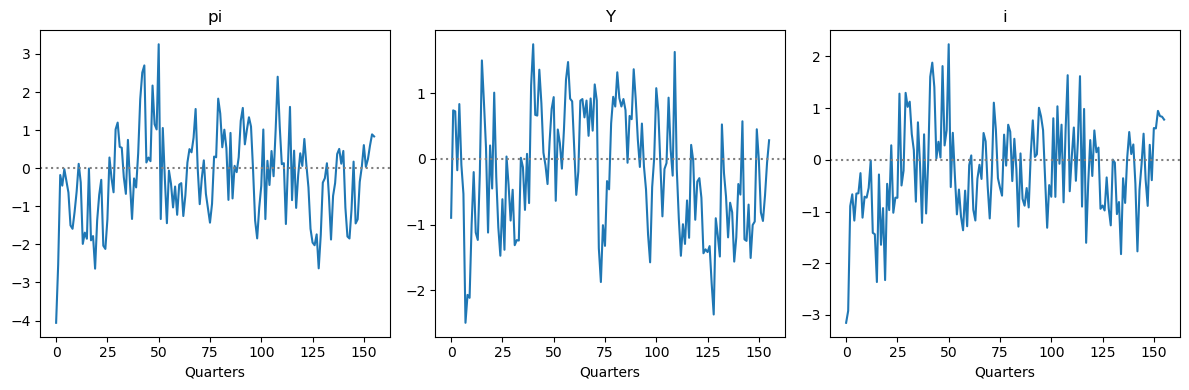

In [14]:
T_sim = 156  # 39 years, as in the original SW (2007) sample

G = ha.solve_jacobian(ss, unknowns, targets, inputs, outputs, T=T)
impulses = shocks.generate_impulses(T)
irfs = {i: G @ {i: impulses[i]} for i in inputs}

data_simul = simulate(list(irfs.values()), outputs, T_sim)
plot_timeseries(data_simul, figsize=(12, 4))

Y = np.empty((T_sim, len(outputs)))
for no, o in enumerate(outputs):
    Y[:, no] = data_simul[o]

In [26]:
# determine the initial draw
theta0 = flatten(shocks.parameters)
labels = [*theta0.keys()]

# define likelihood function
def log_likelihood(shock_parameters):
    theta = unflatten(dict(zip(labels, shock_parameters)))
    shocks.reparameterize(theta)

    # construct impulse response functions
    impulses = shocks.generate_impulses(T)
    irfs = {i: G @ {i: impulses[i]} for i in inputs}
    
    M = np.empty((T, len(outputs), len(inputs)))
    for no, o in enumerate(outputs):
        for ns, s in enumerate(inputs):
            M[:, no, ns] = irfs[s][o]
    
    Sigma = sj.estimation.all_covariances(M, len(inputs))
    
    # step 3: compute log-likelihood
    loglik = sj.estimation.log_likelihood(Y, Sigma)
    logprior = shock_prior.logpdf(theta)
    
    # step 4: add log prior to get log posterior
    return loglik + logprior

In [27]:
theta0

{'ishock_phi[0]': 0.7,
 'ishock_sigma': 1.0,
 'X_phi[0]': 0.8,
 'X_sigma': 0.5,
 'G_phi[0]': 0.7,
 'G_sigma': 0.2}

In [28]:
# TODO: use the support attribute for distributions to set bounds
result = optimize.minimize(
    lambda theta: -log_likelihood(theta),
    [*theta0.values()],
    bounds = [(0.01, 0.99), (0.05, 1.5), (0.01, 0.99), (0.05, 1.5), (0.01, 0.99), (0.05, 1.5)]
)

In [29]:
dict(zip(labels, result.x))

{'ishock_phi[0]': 0.6988780100106378,
 'ishock_sigma': 0.29276519438743337,
 'X_phi[0]': 0.806136676388442,
 'X_sigma': 0.16375122016129365,
 'G_phi[0]': 0.7521648759010511,
 'G_sigma': 0.06798149206256153}

In [ ]:
def log_likelihood(ss, model, model_parameters, shocks, shock_parameters, T):
    # reparameterize the model and solve the jacobian
    ss_new = ss.copy()
    ss_new.update(model_parameters)
    shocks.reparameterize(shock_parameters)
    G = model.solve_jacobian(ss_new, unknowns, targets, inputs, outputs, T=T)
    
    # construct impulse response functions
    impulses = shocks.generate_impulses(T)
    irfs = {i: G @ {i: impulses[i]} for i in inputs}
    
    M = np.empty((T, len(outputs), len(inputs)))
    for no, o in enumerate(outputs):
        for ns, s in enumerate(inputs):
            M[:, no, ns] = irfs[s][o]
    
    Sigma = sj.estimation.all_covariances(M, len(inputs))
    
    # step 3: compute log-likelihood
    loglik = sj.estimation.log_likelihood(Y, Sigma)
    logprior  = shock_prior.logpdf(shock_parameters)
    logprior += model_prior.logpdf(model_parameters)
    
    # step 4: add log prior to get log posterior
    return loglik + logprior